In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

train_path = "./new_train/new_train/"
val_path = "./new_val_in/new_val_in/"

### Check cuda functionality

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce GTX 1060 3GB


### Create a dataset class
Unmodified from the provided `Load_Argoverse_Dataset_Public` notebook

In [3]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data

In [4]:
train_dataset = ArgoverseDataset(data_path = train_path)
val_dataset = ArgoverseDataset(data_path = val_path)

### Exploratory analysis of data

In [5]:
print('Train keys:')
for key in train_dataset[0].keys():
    print(f'Type of \'{key}\': ', end = '')
    item = train_dataset[0][key]
    print(type(item))
print('\nValidation Keys:')
for key in val_dataset[0].keys():
    print(f'Type of \'{key}\': ', end = '')
    item = train_dataset[0][key]
    print(type(item))

Train keys:
Type of 'city': <class 'str'>
Type of 'lane': <class 'numpy.ndarray'>
Type of 'lane_norm': <class 'numpy.ndarray'>
Type of 'scene_idx': <class 'int'>
Type of 'agent_id': <class 'str'>
Type of 'car_mask': <class 'numpy.ndarray'>
Type of 'p_in': <class 'numpy.ndarray'>
Type of 'v_in': <class 'numpy.ndarray'>
Type of 'p_out': <class 'numpy.ndarray'>
Type of 'v_out': <class 'numpy.ndarray'>
Type of 'track_id': <class 'numpy.ndarray'>

Validation Keys:
Type of 'city': <class 'str'>
Type of 'lane': <class 'numpy.ndarray'>
Type of 'lane_norm': <class 'numpy.ndarray'>
Type of 'scene_idx': <class 'int'>
Type of 'agent_id': <class 'str'>
Type of 'car_mask': <class 'numpy.ndarray'>
Type of 'p_in': <class 'numpy.ndarray'>
Type of 'v_in': <class 'numpy.ndarray'>
Type of 'track_id': <class 'numpy.ndarray'>


In [6]:
for key in train_dataset[0].keys():
    item = train_dataset[0][key]
    if type(item) == numpy.ndarray:
        print(f'Size of first 5 instances of \'{key}\': ')
        for i in range(5):
            item = train_dataset[i][key]
            if i == 9:
                print(f'{item.shape}')
            print(f'{item.shape}, ') 
        print()

Size of first 5 instances of 'lane': 
(72, 3), 
(261, 3), 
(288, 3), 
(378, 3), 
(306, 3), 

Size of first 5 instances of 'lane_norm': 
(72, 3), 
(261, 3), 
(288, 3), 
(378, 3), 
(306, 3), 

Size of first 5 instances of 'car_mask': 
(60, 1), 
(60, 1), 
(60, 1), 
(60, 1), 
(60, 1), 

Size of first 5 instances of 'p_in': 
(60, 19, 2), 
(60, 19, 2), 
(60, 19, 2), 
(60, 19, 2), 
(60, 19, 2), 

Size of first 5 instances of 'v_in': 
(60, 19, 2), 
(60, 19, 2), 
(60, 19, 2), 
(60, 19, 2), 
(60, 19, 2), 

Size of first 5 instances of 'p_out': 
(60, 30, 2), 
(60, 30, 2), 
(60, 30, 2), 
(60, 30, 2), 
(60, 30, 2), 

Size of first 5 instances of 'v_out': 
(60, 30, 2), 
(60, 30, 2), 
(60, 30, 2), 
(60, 30, 2), 
(60, 30, 2), 

Size of first 5 instances of 'track_id': 
(60, 30, 1), 
(60, 30, 1), 
(60, 30, 1), 
(60, 30, 1), 
(60, 30, 1), 



In [ ]:
x_in = []
y_in = []
x_out = []
y_out = []
vx = []
vy = []
i = 0
for scene in val_dataset:
    for obj in range(int(sum(scene['car_mask']).item())):
        for x1, y1 in scene['p_in'][obj]:
            x_in += [x1]
            y_in += [y1]
        for x1, y1 in scene['v_in'][obj]:
            vx += [x1]
            vy += [y1]
print('Validation set finished. Starting Train set.')
for scene in train_dataset:
    for obj in range(int(sum(scene['car_mask']).item())):
        for x1, y1 in scene['p_in'][obj]:
            x_in += [x1]
            y_in += [y1]
        for x1, y1 in scene['p_out'][obj]:
            x_out += [x1]
            y_out += [y1]
        for x1, y1 in scene['v_in'][obj]:
            vx += [x1]
            vy += [y1]
        for x1, y1 in scene['v_out'][obj]:
            vx += [x1]
            vy += [y1]
    i += 1
    if i % 10000 == 0:
        print(f'{i} scenes finished.')
print('Train set finished.')

In [ ]:
plt.hist2d(x_in, y_in, range = [[-50, 4750], [200, 4100]], bins = 20)
_ = plt.colorbar()

In [ ]:
plt.hist2d(x_out, y_out, range = [[-100, 4800], [550, 4100]], bins = 20)
_ = plt.colorbar()

In [ ]:
plt.hist2d(vx, vy, range = [[-230, 300], [-190, 280]], bins = 20)
_ = plt.colorbar()

In [ ]:
plt.hist2d(vx, vy, range = [[-20, 20], [-20, 20]], bins = 20)
_ = plt.colorbar()

### Create a loader to enable batch processing

In [7]:
batch_sz = 32

def extract_car_ind(tid, track_id):
    for i, idx in enumerate(track_id, 0):
        if tid == idx[0][0]:
            return i

def my_collate(batch):
    inp = [numpy.dstack([scene['p_in'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    out = [numpy.dstack([scene['p_out'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    inp = torch.Tensor(inp)
    out = torch.Tensor(out)
    return [inp, out]

def my_collate_val(batch):
    inp = [numpy.dstack([scene['p_in'][extract_car_ind(scene['agent_id'], scene['track_id'])]]) for scene in batch]
    inp = torch.Tensor(inp)
    return inp

In [8]:
tr_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate_val, num_workers = 0)

### Create model architecture

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(1, 128)
        self.bn1 = nn.BatchNorm2d(19)
        self.conv1 = nn.Conv2d(19, 512, 1)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 30, 1)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.conv1(x)
        x = self.fc2(x)
        x = F.log_softmax(self.bn2(x), dim = 1)
        x = self.conv2(x)
        x = self.fc3(x)
        return x

### Set up model and parameters

In [10]:
device = 'cuda'

tr_loader = DataLoader(train_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = batch_sz, shuffle = False, collate_fn = my_collate_val, num_workers = 0)

net = Model().to(device)
optimizer = optim.SGD(net.parameters(), lr = 0.000001, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'mean').to(device)

### Train model

In [11]:
e = 5
p = 500
l = []
l_mini = []

net.train()
for epoch in range(e):
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(tr_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        try:
            outputs = net(inputs)
        except RuntimeError:
            print('!')
            continue
        loss = torch.sqrt(criterion(outputs, targets))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_loss += loss.item()
        if i % p == p - 1:
            l_mini += [running_loss / p]
            print('[%d, %5d] loss %.3f' %
                  (epoch + 1, i + 1, running_loss / p))
            running_loss = 0.0
#         if i == 10 * p - 1:
#             break
    print(f'End of epoch {epoch + 1}   loss {total_loss / (i + 1)}')
    l += [total_loss / (i + 1)]
print('Finished Training')

[1,   500] loss 2156.298
[1,  1000] loss 2157.791
[1,  1500] loss 2159.359
[1,  2000] loss 2155.731
[1,  2500] loss 2133.948
[1,  3000] loss 2014.290
[1,  3500] loss 1437.819
[1,  4000] loss 1035.303
[1,  4500] loss 1018.411
[1,  5000] loss 1015.162
[1,  5500] loss 1014.280
[1,  6000] loss 1002.200
End of epoch 1   loss 1567.2400511557305
[2,   500] loss 988.275
[2,  1000] loss 974.248
[2,  1500] loss 952.114
[2,  2000] loss 923.319
[2,  2500] loss 879.245
[2,  3000] loss 825.512
[2,  3500] loss 764.390
[2,  4000] loss 704.474
[2,  4500] loss 634.055
[2,  5000] loss 558.603
[2,  5500] loss 471.809
[2,  6000] loss 355.743
End of epoch 2   loss 717.6972212652155
[3,   500] loss 153.027
[3,  1000] loss 129.249
[3,  1500] loss 114.880
[3,  2000] loss 110.215
[3,  2500] loss 106.531
[3,  3000] loss 102.410
[3,  3500] loss 97.097
[3,  4000] loss 98.131
[3,  4500] loss 100.561
[3,  5000] loss 97.312
[3,  5500] loss 95.795
[3,  6000] loss 96.713
End of epoch 3   loss 107.49260631713014
[4,   5

### Visualize Loss

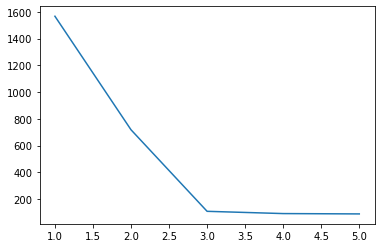

In [12]:
_ = plt.plot(range(1, 6), l)

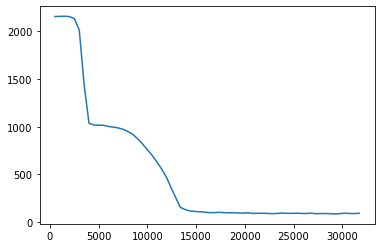

In [13]:
x = []
for e in range(5):
    for p in range(500, 6001, 500):
        x += [e * len(tr_loader) + p]
_ = plt.plot(x, l_mini)

### Visualize Predictions

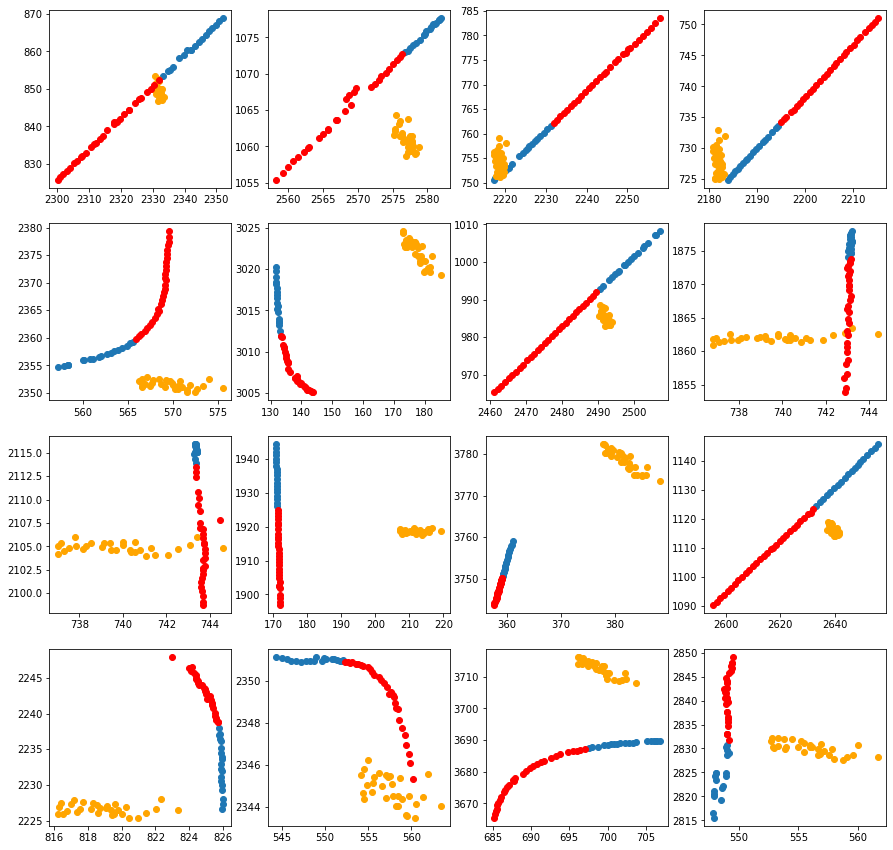

In [19]:
idxs = np.random.randint(0, len(train_dataset), 16)
fig, axes = plt.subplots(4, 4, figsize = (15, 15))
for i in range(4):
    for j in range(4):
        net.eval()
        with torch.no_grad():
            inp = torch.Tensor(train_dataset[idxs[4 * i + j]]['p_in'][extract_car_ind(train_dataset[idxs[4 * i + j]]['agent_id'], train_dataset[idxs[4 * i + j]]['track_id'])]).view(1, 19, 2, 1)
            out = net(inp.to(device))
            true_out = train_dataset[idxs[4 * i + j]]['p_out'][extract_car_ind(train_dataset[idxs[4 * i + j]]['agent_id'], train_dataset[idxs[4 * i + j]]['track_id'])]
            
        x_in = [inp[0][i][0].item() for i in range(19)]
        y_in = [inp[0][i][1].item() for i in range(19)]
        x_out = [out[0][i][0].item() for i in range(30)]
        y_out = [out[0][i][1].item() for i in range(30)]
        x_true_out = [true_out[i][0] for i in range(30)]
        y_true_out = [true_out[i][1] for i in range(30)]

        axes[i, j].scatter(x_in, y_in)
        axes[i, j].scatter(x_out, y_out, c = 'orange')
        axes[i, j].scatter(x_true_out, y_true_out, c = 'red')

### Write predictions to csv

In [28]:
cols = ['ID']
for i in range(1, 61):
    cols += ['v' + str(i)]

l = []
j = 0
net.eval()
for inputs in val_loader:
    with torch.no_grad():
        out = net(inputs.to(device))
    for scene in out:
        row = [val_dataset[j]['scene_idx']]
        j += 1
        for i in range(30):
            row += [scene[i][0].item()]
            row += [scene[i][1].item()]
        l += [row]
df = pd.DataFrame(l, columns = cols)

df.to_csv('submission.csv', index = False)